In [1]:
import random
from collections import Counter
import numpy as np
import json
import os

In [2]:
# Define a dictionary of gestures used in the game, with their winning moves, winning points, and losing points.
gestures = {
    "Rock": {"wins": ["Scissors", "Lizard"], "winning_points": 1, "losing_points": -1},
    "Paper": {"wins": ["Rock", "Spock"], "winning_points": 2, "losing_points": -2},
    "Scissors": {"wins": ["Paper", "Lizard"], "winning_points": 3, "losing_points": -3},
    "Lizard": {"wins": ["Spock", "Paper"], "winning_points": 4, "losing_points": -4},
    "Spock": {"wins": ["Scissors", "Rock"], "winning_points": 5, "losing_points": -5}
}

In [3]:
# Define the counter moves for each gesture.
counter_moves = {
    "Rock": ["Paper", "Spock"],
    "Paper": ["Scissors", "Lizard"],
    "Scissors": ["Spock", "Rock"],
    "Lizard": ["Rock", "Scissors"],
    "Spock": ["Lizard", "Paper"]
}

In [4]:
# Function to calculate the payoff matrix based on the gestures dictionary
def calculate_payoff_matrix():
    # Initialize an empty dictionary for the payoff matrix
    payoff_matrix = {}
    # Iterate through each gesture and its outcomes
    for gesture, outcomes in gestures.items():
        # Initialize an inner dictionary for the current gesture
        payoff_matrix[gesture] = {}
        # For each gesture, determine the payoff against other gestures
        for outcome in gestures.keys():
            if outcome in outcomes["wins"]:
                payoff = outcomes["winning_points"]
            elif outcome == gesture:
                payoff = 0
            else:
                payoff = outcomes["losing_points"]
            payoff_matrix[gesture][outcome] = payoff
    return payoff_matrix

In [5]:
# Function to print the payoff matrix for visualization
def print_payoff_matrix(matrix):
    # Print header for the payoff matrix
    print("Payoff Matrix:")
    print("{:<8}".format(""), end="")
    # Print the header row with all gesture names
    for gesture in matrix.keys():
        print("{:<10}".format(gesture), end="")
    print()
    # Print each row of the payoff matrix
    for gesture, outcomes in matrix.items():
        print("{:<8}".format(gesture), end="")
        for outcome in outcomes.values():
            print("{:<10}".format(outcome), end="")
        print()

In [6]:
payoff_matrix = calculate_payoff_matrix()
print_payoff_matrix(payoff_matrix)

Payoff Matrix:
        Rock      Paper     Scissors  Lizard    Spock     
Rock    0         -1        1         1         -1        
Paper   2         0         -2        -2        2         
Scissors-3        3         0         3         -3        
Lizard  -4        4         -4        0         4         
Spock   5         -5        5         -5        0         


In [7]:
# Function to determine the outcome of a round based on player choices
def determine_outcome(player1_choice, player2_choice):
    # Check if player1's choice wins over player2's choice
    if player2_choice in gestures[player1_choice]["wins"]:
        return "Player 1", gestures[player1_choice]["winning_points"]
    # Check if player2's choice wins over player1's choice
    elif player1_choice in gestures[player2_choice]["wins"]:
        return "Player 2", gestures[player2_choice]["winning_points"]
    # If neither player wins, it's a draw
    else:
        return "Draw", 0

In [8]:
# Base class for defining different strategies in the game.
class Strategy:
    # Function to determine the next move based on the game history.
    # This method should be implemented by subclasses to provide different strategies.
    def next_move(self, history):
        raise NotImplementedError

In [9]:
# Define strategies as subclasses of Strategy
class RandomStrategy(Strategy):
    def next_move(self, history):
        return random.choice(list(gestures.keys()))


In [10]:
class RockStrategy(Strategy):
    def next_move(self, history):
        return 'Rock'

In [11]:
class PaperStrategy(Strategy):
    def next_move(self, history):
        return 'Paper'

In [12]:
class ScissorsStrategy(Strategy):
    def next_move(self, history):
        return 'Scissors'

In [13]:
class LizardStrategy(Strategy):
    def next_move(self, history):
        return 'Lizard'

In [14]:
class SpockStrategy(Strategy):
    def next_move(self, history):
        return 'Spock'

In [15]:
class FixedHighestPayoffStrategy(Strategy):
    def next_move(self, history):
        return random.choice(['Lizard', 'Spock'])


In [16]:
class FixedLowestPayoffStrategy(Strategy):
    def next_move(self, history):
        return random.choice(['Rock', 'Paper', 'Scissors'])


In [17]:
# strategy would analyze the opponent's last move and react with a gesture that would have beaten it, assuming the opponent doesn't change their strategy.
class ReactiveStrategy(Strategy):
    def next_move(self, history):
        if not history:
            return random.choice(list(gestures.keys()))
        last_opponent_move = history[-1][1]
        return random.choice(gestures[last_opponent_move]["wins"])


In [18]:
# Adaptive player class with short memory
class AdaptivePlayerShortMemory(Strategy):
    def __init__(self):
        self.memory = []

    def record_opponent_choice(self, choice):
        self.memory.append(choice)
        if len(self.memory) > 10:  # Keep only the last 10 moves
            self.memory.pop(0)

    def next_move(self, history):
        if not history:
            return random.choice(list(gestures.keys()))
        self.record_opponent_choice(history[-1][1])  # Record opponent's last choice
        most_common_choice = Counter(self.memory).most_common(1)[0][0]
        return counter_moves[most_common_choice][0]

In [19]:
# Adaptive player class with long memory
class AdaptivePlayerLongMemory(Strategy):
    def __init__(self):
        self.memory = []

    def record_opponent_choice(self, choice):
        self.memory.append(choice)

    def next_move(self, history):
        if not history:
            return random.choice(list(gestures.keys()))
        self.record_opponent_choice(history[-1][1])  # Record opponent's last choice
        most_common_choice = Counter(self.memory).most_common(1)[0][0]
        return counter_moves[most_common_choice][0]


In [20]:
# This strategy chooses the gesture that the opponent has used the least, assuming they are less likely to use it next.
class LeastUsedStrategy(Strategy):
    def next_move(self, history):
        if not history:
            return random.choice(list(gestures.keys()))
        opponent_moves = [move[1] for move in history]
        move_frequency = {move: opponent_moves.count(move) for move in gestures}
        least_frequent_move = min(move_frequency, key=move_frequency.get)
        return random.choice(gestures[least_frequent_move]["wins"])


In [21]:
# Opposite to the LeastUsed strategy, this one assumes the opponent will continue to use their most frequent move.
class MostUsedStrategy(Strategy):
    def next_move(self, history):
        if not history:
            return random.choice(list(gestures.keys()))
        opponent_moves = [move[1] for move in history]
        move_frequency = {move: opponent_moves.count(move) for move in gestures}
        most_frequent_move = max(move_frequency, key=move_frequency.get)
        return random.choice(gestures[most_frequent_move]["wins"])


In [22]:
# This strategy cycles through the gestures in a fixed sequence, potentially making it predictable but also reliable against random strategies. 
class SequentialStrategy(Strategy):
    def __init__(self):
        self.sequence = list(gestures.keys())
        self.index = 0
        
    def next_move(self, history):
        choice = self.sequence[self.index]
        self.index = (self.index + 1) % len(self.sequence)
        return choice


In [23]:
# (Pavlov):
# This strategy repeats the last choice if it won, otherwise it shifts to a different random choice.
class WinStayLoseShiftStrategy(Strategy):
    def __init__(self):
        self.last_move = None
        self.last_result = None

    def next_move(self, history):
        if not history or self.last_result == "Draw":
            self.last_move = random.choice(list(gestures.keys()))
        elif self.last_result == "Player 2":
            all_moves = list(gestures.keys())
            all_moves.remove(self.last_move)
            self.last_move = random.choice(all_moves)
        return self.last_move

    def update_last_result(self, result):
        self.last_result = result


In [24]:
class TryToLoseStrategy(Strategy):
    def __init__(self, player_1_2=1, memory_length=10):
        self.player = player_1_2
        self.memory_length = memory_length

    def next_move(self, history):
        if not history:
            return random.choice(list(gestures.keys()))

        if self.player == 1:
            opponent_moves = [it[1] for it in history]
        else:
            opponent_moves = [it[0] for it in history]

        if len(opponent_moves) > self.memory_length:
            opponent_moves = opponent_moves[-self.memory_length:]

        move_frequency = Counter(opponent_moves)
        most_frequent_move = move_frequency.most_common(1)[0][0]

        # Get the losing move to the opponent's most frequent move
        # Assume the counter_moves dictionary has moves that would be lost to
        try_to_lose_move = [move for move in gestures if most_frequent_move in gestures[move]["wins"]]
        return random.choice(try_to_lose_move) if try_to_lose_move else random.choice(list(gestures.keys()))


In [25]:
## ADD COPY STRATEGY
class CopyStrategy(Strategy):
    def __init__(self):
        self.last_move = None

    def next_move(self, history):
        if not history:
            # If there is no history yet, make a random choice
            return random.choice(list(gestures.keys()))
        else:
            # Copy the opponent's last move
            self.last_move = history[-1][0]  # Assuming history is a list of tuples (player1_choice, player2_choice)
            return self.last_move



In [26]:
# Q-Learning strategy class, a form of reinforcement learning.

class QLearningStrategy(Strategy):
    
    # Initialization method for the QLearningStrategy class.
    
    # state_size: Number of states in the Q-table
    # actions: List of possible actions (e.g., ["Rock", "Paper", "Scissors", "Lizard", "Spock"])
    # alpha: Learning rate
    # gamma: Discount factor for future rewards
    # epsilon: Exploration rate, for choosing random actions
    # min_epsilon: Minimum exploration rate
    # epsilon_decay: Decay rate for exploration over time
    
    def __init__(self, actions, state_size=41, alpha=0.7, gamma=0.9, epsilon=1.0, min_epsilon=0.01, epsilon_decay=0.995):
        self.q_table = np.zeros((state_size, len(actions)))  # Initialize the Q-table with zeros
        self.actions = actions  # Set the possible actions
        self.state_size = state_size  # Set the state size
        self.alpha = alpha  # Set the learning rate
        self.gamma = gamma  # Set the discount factor
        self.epsilon = epsilon  # Set the exploration rate
        self.min_epsilon = min_epsilon  # Set the minimum exploration rate
        self.epsilon_decay = epsilon_decay  # Set the exploration decay rate
        self.current_state = 20  # Default to a neutral state index

    # Method to choose an action based on the current state.
    def choose_action(self, state):
    
        
        if random.random() < self.epsilon: # Decide whether to explore or exploit
            return random.choice(self.actions) # Explore: choose a random action
        else:
            return self.actions[np.argmax(self.q_table[state])] # Exploit

    


    def learn(self, state, action_index, reward, next_state):
        # If action is already an index, there's no need to find the index again
        q_predict = self.q_table[state, action_index]
        q_target = reward + self.gamma * np.max(self.q_table[next_state])
        self.q_table[state, action_index] += self.alpha * (q_target - q_predict)

    
    def update_for_external_state(self, player1_score, player2_score):
        # Method to update the current_state based on external information
        self.current_state = self.update_state(player1_score, player2_score)
   
  
    def next_move(self, _):
        # Directly use self.current_state updated externally
        if random.random() < self.epsilon:
            # Exploration: choose a random action
            action = random.choice(self.actions)
        else:
            # Exploitation: choose the best action from the Q-table for the current state
            action_index = np.argmax(self.q_table[self.current_state])
            action = self.actions[action_index]
        return action
            
    def update_state(self, player1_score, player2_score):
        score_diff = player1_score - player2_score
        return max(0, min(self.state_size - 1, score_diff + 20))
    
    

    def save(self, filepath='q_table.json'):
        data = self.q_table.tolist()
        with open(filepath, 'w') as f:
            json.dump(data, f, indent=4)

    def load(self, filepath='q_table.json'):
        if os.path.exists(filepath):
            with open(filepath, 'r') as f:
                self.q_table = np.array(json.load(f))

# Usage example:
q_learning_strategy = QLearningStrategy(actions=["Rock", "Paper", "Scissors", "Lizard", "Spock"])


In [27]:
class QLearningTrainer:
    def __init__(self, strategy, num_episodes=1000):  
        self.strategy = strategy
        self.num_episodes = num_episodes
        self.rewards = []  # To track rewards over time

    def simulate_action(self, state):
        """Simulates taking an action in the environment."""
        # Placeholder for your action simulation logic
        action = self.strategy.choose_action(state)
        new_state = np.random.randint(0, self.strategy.state_size)  # Example new state
        reward = np.random.randint(-1, 2)  # Example reward
        return new_state, action, reward

    def train(self):
        """Runs the training sessions."""
        for episode in range(self.num_episodes):
            state = self.strategy.current_state
            new_state, action, reward = self.simulate_action(state)
            action_index = self.strategy.actions.index(action)
            self.strategy.learn(state, action_index, reward, new_state)
            self.rewards.append(reward)
            # Update current state for the next round
            self.strategy.current_state = new_state
            # Optionally decay epsilon here to reduce exploration over time

        # Save the trained Q-table for later use
        self.strategy.save()


In [28]:
# Initialize the QLearningStrategy with defined actions
q_learning_strategy = QLearningStrategy(actions=["Rock", "Paper", "Scissors", "Lizard", "Spock"])

# Initialize the trainer with the QLearningStrategy instance
trainer = QLearningTrainer(q_learning_strategy)

# Run the training process
trainer.train()

# After training, you can optionally save the trained Q-table to a file
q_learning_strategy.save('trained_q_table.json')

# And load it whenever needed
q_learning_strategy.load('trained_q_table.json')


In [29]:
class Player:
    def __init__(self, strategy):
        self.strategy = strategy
        self.score = 0
        self.choice = None

    def choose_gesture(self, history):
        self.choice = self.strategy.next_move(history)
        return self.choice

    def update_score(self, points):
        self.score += points

In [30]:
class Game:
    def __init__(self, player1_strategy, player2_strategy, num_rounds=1000):
        self.player1 = Player(player1_strategy)
        self.player2 = Player(player2_strategy)
        self.num_rounds = num_rounds
        self.history = []

    def play_round(self):
        if hasattr(self.player1.strategy, 'update_state'):
            state = self.player1.strategy.update_state(self.player1.score, self.player2.score)
        else:
            state = None  # Or some default value if needed

        player1_action = self.player1.choose_gesture(self.history)
        player2_action = self.player2.choose_gesture(self.history)
        
        outcome, points = determine_outcome(player1_action, player2_action)

        if state is not None and hasattr(self.player1.strategy, 'update_state'):
            next_state = self.player1.strategy.update_state(self.player1.score, self.player2.score)
        else:
            next_state = None  # Or some default value if needed
        
        # Update Q-table if player1 uses QLearningStrategy
        if isinstance(self.player1.strategy, QLearningStrategy):
            action_index = self.player1.strategy.actions.index(player1_action)
            self.player1.strategy.learn(state, action_index, points, next_state)
        
        self.update_scores(outcome, points, player1_action, player2_action)
        self.history.append((player1_action, player2_action))
        
        
    def update_scores(self, outcome, points, player1_choice, player2_choice):
        if outcome == "Player 1":
            self.player1.update_score(points)
            self.player2.update_score(gestures[player2_choice]["losing_points"])
        elif outcome == "Player 2":
            self.player2.update_score(points)
            self.player1.update_score(gestures[player1_choice]["losing_points"])

    def print_round_info(self, player1_choice, player2_choice):
        outcome = self.history[-1] if self.history else "Draw"
        print(f"Player 1 choice: {player1_choice}, Player 2 choice: {player2_choice}")
        print(f"Outcome: {outcome}")
        print(f"Scores -> Player 1: {self.player1.score}, Player 2: {self.player2.score}")

    def play(self):
        for _ in range(self.num_rounds):
            self.play_round()
        self.declare_winner()

    def declare_winner(self):
        if self.player1.score > self.player2.score:
            print(f"The winner after {self.num_rounds} rounds is Player 1!")
        elif self.player2.score > self.player1.score:
            print(f"The winner after {self.num_rounds} rounds is Player 2!")
        else:
            print("The game is a draw after 100 rounds.")

In [31]:
def run_simulation(player1_strategy, player2_strategy, num_rounds=1000):
    game = Game(player1_strategy, player2_strategy, num_rounds)
    game.play()
    return game.player1.score, game.player2.score

In [32]:
import matplotlib.pyplot as plt
import numpy as np

def compare_strategies(strategy1, strategy2, num_rounds=1000, num_simulations=15):
    """
    Compares two strategies by running simulations and visualizing the winning rates.

    Parameters:
    - strategy1: The first strategy object to be compared.
    - strategy2: The second strategy object to be compared.
    - num_rounds: Number of rounds to be played in each game.
    - num_simulations: Number of simulations to run.
    """
    wins_strategy1 = 0
    wins_strategy2 = 0
    win_rates_strategy1 = []
    win_rates_strategy2 = []

    for simulation_index in range(num_simulations):
        # Run simulation
        score_strategy1, score_strategy2 = run_simulation(strategy1, strategy2, num_rounds)

        # Determine winner
        if score_strategy1 > score_strategy2:
            wins_strategy1 += 1
        elif score_strategy2 > score_strategy1:
            wins_strategy2 += 1

        # Calculate and store win rates
        win_rates_strategy1.append((wins_strategy1 / (simulation_index + 1)) * 100)
        win_rates_strategy2.append((wins_strategy2 / (simulation_index + 1)) * 100)

    # Plotting the results
    indices = np.arange(num_simulations)
    width = 0.35

    fig, ax = plt.subplots()
    bar1 = ax.bar(indices - width/2, win_rates_strategy1, width, label=strategy1.__class__.__name__)
    bar2 = ax.bar(indices + width/2, win_rates_strategy2, width, label=strategy2.__class__.__name__)

    ax.set_xlabel('Simulation Index')
    ax.set_ylabel('Winning Rate (%)')
    ax.set_title('Winning Rate Comparison')
    ax.set_xticks(indices)
    ax.set_xticklabels([str(i+1) for i in indices])
    ax.legend()

    plt.show()


In [33]:
def compare_strategies_overall_result(strategy1, strategy2, num_rounds=1000, num_simulations=15):
    """
    Compares two strategies by running simulations and visualizing the winning rates using the Game class.

    Parameters:
    - strategy1: The first strategy object to be compared.
    - strategy2: The second strategy object to be compared.
    - num_rounds: Number of rounds to be played in each game.
    - num_simulations: Number of simulations to run.
    """
    wins_strategy1 = 0
    wins_strategy2 = 0

    for _ in range(num_simulations):
        # Initialize and play the game
        game = Game(strategy1, strategy2, num_rounds)
        game.play()
        
        # Use custom logic or a method from Game to determine the winner
        if game.player1.score > game.player2.score:
            wins_strategy1 += 1
        elif game.player2.score > game.player1.score:
            wins_strategy2 += 1

    # Calculate win rates
    win_rate_strategy1 = (wins_strategy1 / num_simulations) * 100
    win_rate_strategy2 = (wins_strategy2 / num_simulations) * 100

    # Plotting the results
    strategies = [strategy1.__class__.__name__, strategy2.__class__.__name__]
    win_rates = [win_rate_strategy1, win_rate_strategy2]

    plt.figure(figsize=(10, 6))
    plt.bar(strategies, win_rates, color=['blue', 'orange'])
    plt.xlabel('Strategy')
    plt.ylabel('Winning Rate (%)')
    plt.title('Winning Rate Comparison Between Strategies')
    plt.ylim(0, 100)
    plt.show()

# Create all different types of combinations

## Random

In [34]:
# Random vs fixed highest
random_vs_fixed_h = Game(RandomStrategy(), FixedHighestPayoffStrategy())
random_vs_fixed_h.play()

The winner after 1000 rounds is Player 2!


In [35]:
# Random vs fixed lowest
random_vs_fixed_l = Game(RandomStrategy(), FixedLowestPayoffStrategy())
random_vs_fixed_l.play()

The winner after 1000 rounds is Player 2!


In [36]:
# Random vs copy
random_vs_copy = Game (RandomStrategy(), CopyStrategy())
random_vs_copy.play()

The winner after 1000 rounds is Player 1!


In [37]:
# Random vs Adaptive Long Memory
random_vs_adaptive = Game (RandomStrategy(), AdaptivePlayerShortMemory())
random_vs_adaptive.play()

The winner after 1000 rounds is Player 2!


In [38]:
# Random vs Adaptive Short Memory 
random_vs_adaptive = Game (RandomStrategy(), AdaptivePlayerLongMemory())
random_vs_adaptive.play()

The winner after 1000 rounds is Player 1!


In [39]:
# Random vs Try to Lose
random_vs_try_to_lose = Game (RandomStrategy(), TryToLoseStrategy())
random_vs_try_to_lose.play()

The winner after 1000 rounds is Player 1!


In [40]:
# Here's how you can use the CopyStrategy in the Game class:
copy_vs_random_game = Game(CopyStrategy(), RandomStrategy())
copy_vs_random_game.play()


The winner after 1000 rounds is Player 2!


In [41]:
# Example usage:
q_learning_vs_random_game = Game(QLearningStrategy(actions=["Rock", "Paper", "Scissors", "Lizard", "Spock"]), RandomStrategy())
q_learning_vs_random_game.play()


The winner after 1000 rounds is Player 2!


## Fixed

In [42]:
# Fixed vs Copy
fixed_vs_copy = Game (FixedHighestPayoffStrategy(), CopyStrategy())
fixed_vs_copy.play()

The winner after 1000 rounds is Player 2!


In [43]:
# Fixed vs Adaptive Long Memory
fixed_vs_adaptive = Game (FixedHighestPayoffStrategy(), AdaptivePlayerLongMemory())
fixed_vs_adaptive.play()

The winner after 1000 rounds is Player 1!


In [44]:
# Fixed vs Adaptive Short Memory
fixed_vs_adaptive = Game (FixedHighestPayoffStrategy(), AdaptivePlayerShortMemory())
fixed_vs_adaptive.play()

The winner after 1000 rounds is Player 1!


In [45]:
# Fixed vs Try to Lose
fixed_vs_try_to_lose = Game (FixedHighestPayoffStrategy(), TryToLoseStrategy())
fixed_vs_try_to_lose.play()

The winner after 1000 rounds is Player 2!


## Copy

In [46]:
# Copy vs Adaptive Long Memory
copy_vs_adaptive = Game(CopyStrategy(), AdaptivePlayerLongMemory())
copy_vs_adaptive.play()

The winner after 1000 rounds is Player 2!


In [47]:
# Copy vs Adaptive Short  Memory
copy_vs_adaptive = Game(CopyStrategy(), AdaptivePlayerShortMemory())
copy_vs_adaptive.play()

The winner after 1000 rounds is Player 1!


In [48]:
# Copy vs Try to Lose
copy_vs_try_to_lose = Game(CopyStrategy(), TryToLoseStrategy())
copy_vs_try_to_lose.play()

The winner after 1000 rounds is Player 2!


## Adaptive

In [49]:
#Adaptive Long Memory vs Try to Lose
adaptive_vs_try_to_lose = Game(AdaptivePlayerLongMemory(), TryToLoseStrategy())
adaptive_vs_try_to_lose.play()

The winner after 1000 rounds is Player 1!


In [50]:
#Adaptive Short Memory vs Try to Lose
adaptive_vs_try_to_lose = Game(AdaptivePlayerShortMemory(), TryToLoseStrategy())
adaptive_vs_try_to_lose.play()

The winner after 1000 rounds is Player 1!


In [51]:
#Adaptive Short Memory vs Adaptive Long Memory
adaptive_vs_adaptive = Game(AdaptivePlayerShortMemory(), AdaptivePlayerLongMemory())
adaptive_vs_adaptive.play()

The winner after 1000 rounds is Player 2!


In [52]:
import matplotlib.pyplot as plt

# Function to plot the winning trends
def plot_winning_trends(wins_player1, wins_player2):
    num_games = range(1, len(wins_player1) + 1)
    plt.plot(num_games, wins_player1, label='Player 1 Wins')
    plt.plot(num_games, wins_player2, label='Player 2 Wins')
    plt.xlabel('Number of Games')
    plt.ylabel('Wins')
    plt.title('Winning Trends')
    plt.legend()
    plt.show()

# Function to plot the score distribution
def plot_score_distribution(scores_player1, scores_player2):
    plt.hist(scores_player1, bins=20, alpha=0.5, label='Player 1 Scores')
    plt.hist(scores_player2, bins=20, alpha=0.5, label='Player 2 Scores')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.title('Score Distribution')
    plt.legend()
    plt.show()

# Function to compare the performance of different player strategies
def plot_strategy_comparison(strategies, wins):
    plt.bar(strategies, wins)
    plt.xlabel('Strategies')
    plt.ylabel('Wins')
    plt.title('Strategy Comparison')
    plt.show()

# Function to plot the move distribution
def plot_move_distribution(move_counts_player1, move_counts_player2):
    gestures_list = list(gestures.keys())
    width = 0.35
    x = range(len(gestures_list))

    fig, ax = plt.subplots()
    ax.bar(x, move_counts_player1, width, label='Player 1')
    ax.bar([i + width for i in x], move_counts_player2, width, label='Player 2')

    ax.set_xlabel('Gestures')
    ax.set_ylabel('Frequency')
    ax.set_title('Move Distribution')
    ax.set_xticks([i + width / 2 for i in x])
    ax.set_xticklabels(gestures_list)
    ax.legend()

    plt.show()

# Example usage:
# You need to collect data such as wins, scores, strategies, and move counts from your simulations 
# and pass them as arguments to these functions to generate the


The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!


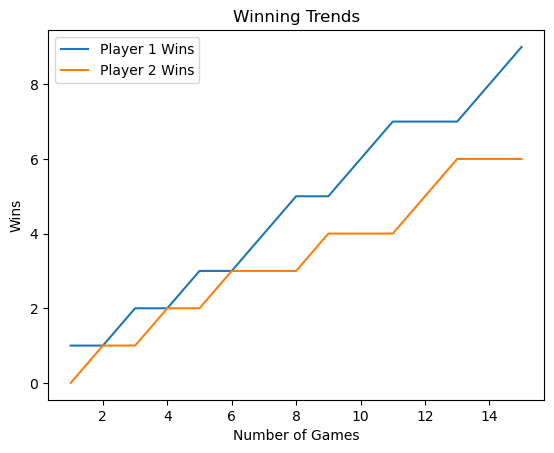

In [53]:
# Initialize lists to store the wins for each player
player1_wins_list = []
player2_wins_list = []

# Define the number of games to play
num_games = 15

# Play multiple games and collect the results
for _ in range(num_games):
    # Create a new instance of the game
    lose_vs_random = Game(TryToLoseStrategy(), RandomStrategy())
    # Play the game
    lose_vs_random.play()
    # Check the winner of each game and update the win lists
    if lose_vs_random.player1.score > lose_vs_random.player2.score:
        player1_wins_list.append(1)
        player2_wins_list.append(0)
    elif lose_vs_random.player2.score > lose_vs_random.player1.score:
        player1_wins_list.append(0)
        player2_wins_list.append(1)
    else:
        player1_wins_list.append(0)
        player2_wins_list.append(0)

# Calculate cumulative wins for each player
cumulative_wins_player1 = [sum(player1_wins_list[:i+1]) for i in range(num_games)]
cumulative_wins_player2 = [sum(player2_wins_list[:i+1]) for i in range(num_games)]

# Plot the winning trends
plot_winning_trends(cumulative_wins_player1, cumulative_wins_player2)


The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Pl

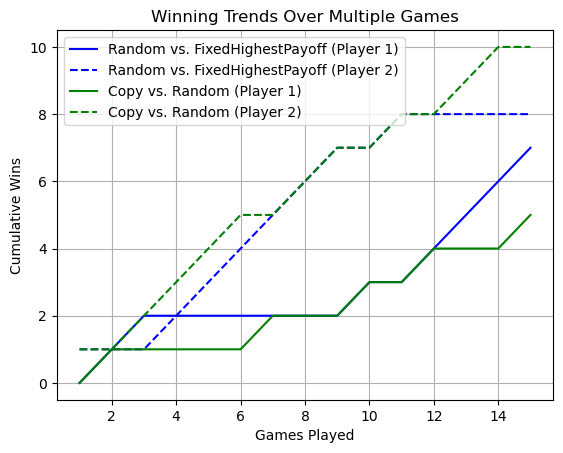

In [54]:
import matplotlib.pyplot as plt

# Function to plot winning trends
def plot_winning_trends(player1_wins, player2_wins):
    # Create a list of colors for each scenario
    colors = ['b', 'g', 'r']
    # Plot the winning trends for Player 1 and Player 2 for each scenario
    for i, (scenario, wins) in enumerate(player1_wins.items()):
        plt.plot(range(1, len(wins) + 1), wins, label=f'{scenario} (Player 1)', color=colors[i])
        plt.plot(range(1, len(player2_wins[scenario]) + 1), player2_wins[scenario], label=f'{scenario} (Player 2)', linestyle='dashed', color=colors[i])

    # Add labels and legend
    plt.xlabel('Games Played')
    plt.ylabel('Cumulative Wins')
    plt.title('Winning Trends Over Multiple Games')
    plt.legend()
    plt.grid(True)
    # Show the plot
    plt.show()

# Initialize lists to store the wins for each player for each scenario
player1_wins_lists = {
    "Random vs. FixedHighestPayoff": [],
    "Copy vs. Random": []
}
player2_wins_lists = {
    "Random vs. FixedHighestPayoff": [],
    "Copy vs. Random": []
}

# Define the number of games to play
num_games = 15

# Play each scenario for multiple games and collect the results
for _ in range(num_games):
    # Random vs. FixedHighestPayoff
    random_vs_fixed = Game(RandomStrategy(), FixedHighestPayoffStrategy())
    random_vs_fixed.play()
    if random_vs_fixed.player1.score > random_vs_fixed.player2.score:
        player1_wins_lists["Random vs. FixedHighestPayoff"].append(1)
        player2_wins_lists["Random vs. FixedHighestPayoff"].append(0)
    elif random_vs_fixed.player2.score > random_vs_fixed.player1.score:
        player1_wins_lists["Random vs. FixedHighestPayoff"].append(0)
        player2_wins_lists["Random vs. FixedHighestPayoff"].append(1)
    else:
        player1_wins_lists["Random vs. FixedHighestPayoff"].append(0)
        player2_wins_lists["Random vs. FixedHighestPayoff"].append(0)

    # Copy vs. Random
    copy_vs_random_game = Game(CopyStrategy(), RandomStrategy())
    copy_vs_random_game.play()
    if copy_vs_random_game.player1.score > copy_vs_random_game.player2.score:
        player1_wins_lists["Copy vs. Random"].append(1)
        player2_wins_lists["Copy vs. Random"].append(0)
    elif copy_vs_random_game.player2.score > copy_vs_random_game.player1.score:
        player1_wins_lists["Copy vs. Random"].append(0)
        player2_wins_lists["Copy vs. Random"].append(1)
    else:
        player1_wins_lists["Copy vs. Random"].append(0)
        player2_wins_lists["Copy vs. Random"].append(0)

# Calculate cumulative wins for each scenario
cumulative_wins_player1 = {}
cumulative_wins_player2 = {}
for scenario, wins_list in player1_wins_lists.items():
    cumulative_wins_player1[scenario] = [sum(wins_list[:i+1]) for i in range(num_games)]
for scenario, wins_list in player2_wins_lists.items():
    cumulative_wins_player2[scenario] = [sum(wins_list[:i+1]) for i in range(num_games)]

# Plot the winning trends for each scenario
plot_winning_trends(cumulative_wins_player1, cumulative_wins_player2)


#  Visualization 1 - bar chart

The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!


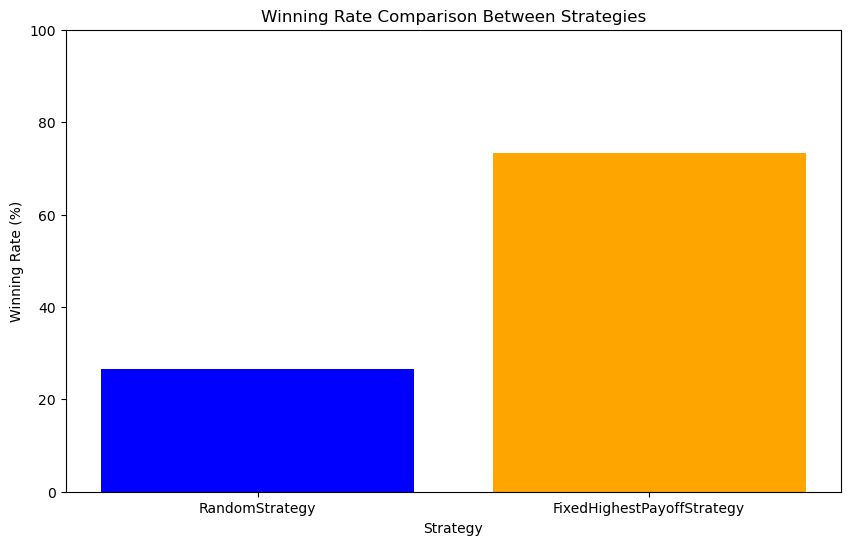

In [55]:
strategy1 = RandomStrategy()
strategy2 = FixedHighestPayoffStrategy()
compare_strategies_overall_result(strategy1, strategy2)

The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!


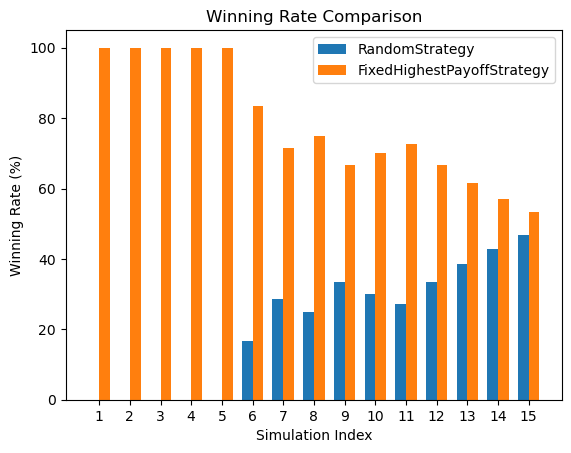

In [56]:
strategy1 = RandomStrategy()
strategy2 = FixedHighestPayoffStrategy()
compare_strategies(strategy1, strategy2)

The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!


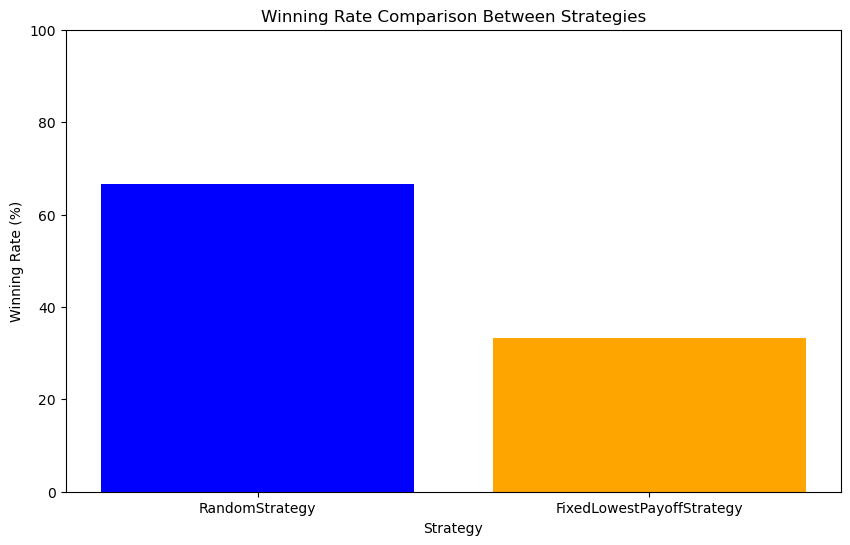

In [57]:
strategy1 = RandomStrategy()
strategy2 = FixedLowestPayoffStrategy()
compare_strategies_overall_result(strategy1, strategy2)

The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!


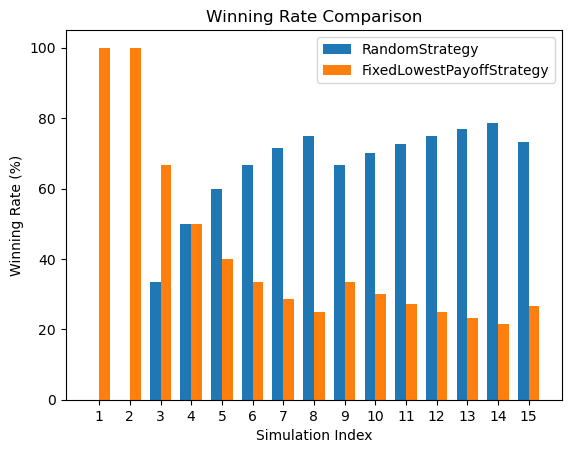

In [58]:
strategy1 = RandomStrategy()
strategy2 = FixedLowestPayoffStrategy()
compare_strategies(strategy1, strategy2)

The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The game is a draw after 100 rounds.
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!


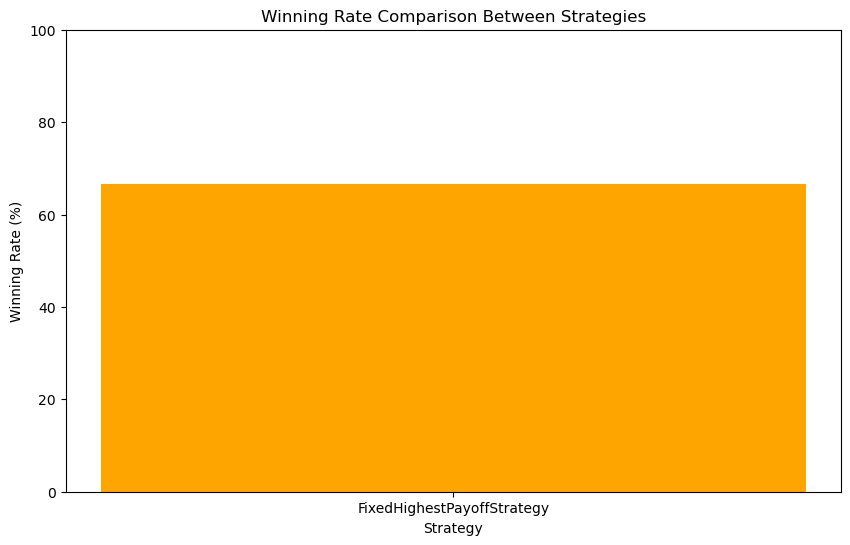

In [59]:
strategy1 = FixedHighestPayoffStrategy()
strategy2 = FixedHighestPayoffStrategy()
compare_strategies_overall_result(strategy1, strategy2)

The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!


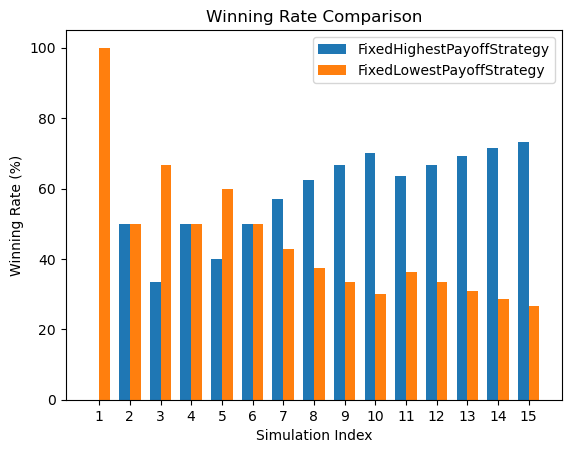

In [60]:
strategy1 = FixedHighestPayoffStrategy()
strategy2 = FixedLowestPayoffStrategy()
compare_strategies(strategy1, strategy2)

In [61]:
def plot_theoretical_payoffs(fixed_strategy_name, fixed_strategy_payoff, random_payoff, num_matches=15, num_rounds=1000):
    # Calculate payoffs for each game within each match
    fixed_game_payoffs = [fixed_strategy_payoff * num_rounds] * num_matches
    random_game_payoffs = [random_payoff * num_rounds] * num_matches

    bar_width = 0.4
    index = np.arange(num_matches)

    plt.bar(index - bar_width/2, fixed_game_payoffs, width=bar_width, label= fixed_strategy_name, color='blue')
    plt.bar(index + bar_width/2, random_game_payoffs, width=bar_width, label='Random Strategy', color='orange')
    
    plt.xlabel('Match Number')
    plt.ylabel('Total Payoff')
    plt.title('Theoretical Total Payoff for Each Game in 10 Matches of 100 Rounds')
    plt.xticks(index)
    plt.legend()
    plt.tight_layout()
    plt.show()




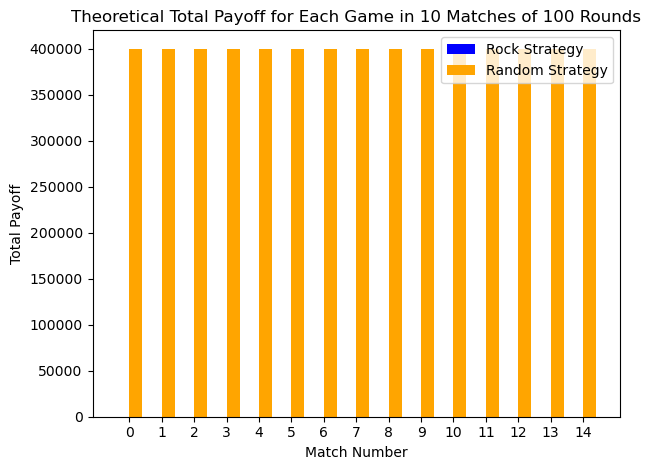

In [62]:
# Call the function with the specified payoffs
plot_theoretical_payoffs(fixed_strategy_name = 'Rock Strategy', fixed_strategy_payoff=0, random_payoff=400)

The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!


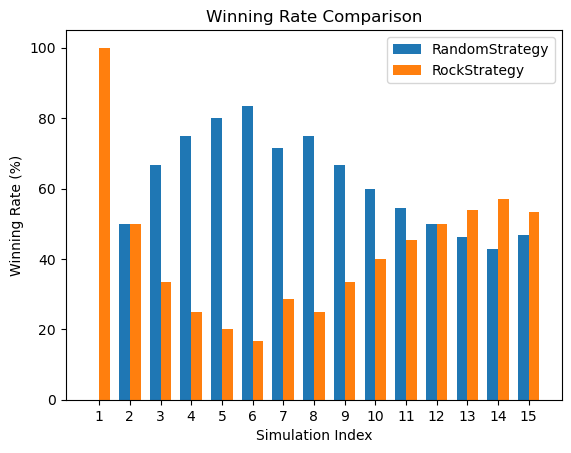

In [63]:
compare_strategies(RandomStrategy(), RockStrategy())

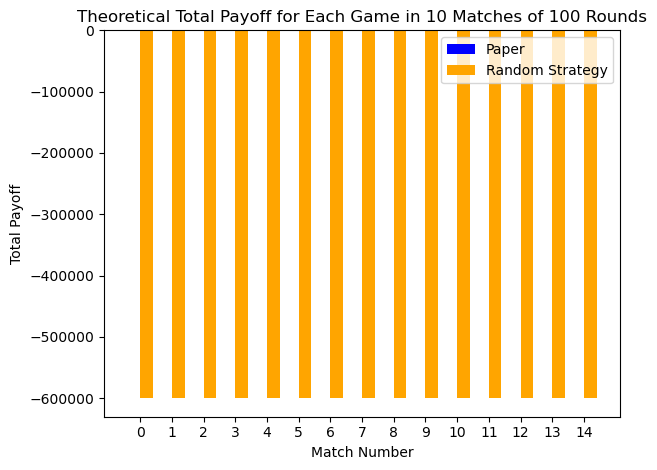

In [64]:
# Call the function with the specified payoffs
plot_theoretical_payoffs(fixed_strategy_name = 'Paper', fixed_strategy_payoff=0, random_payoff=-600)

The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!


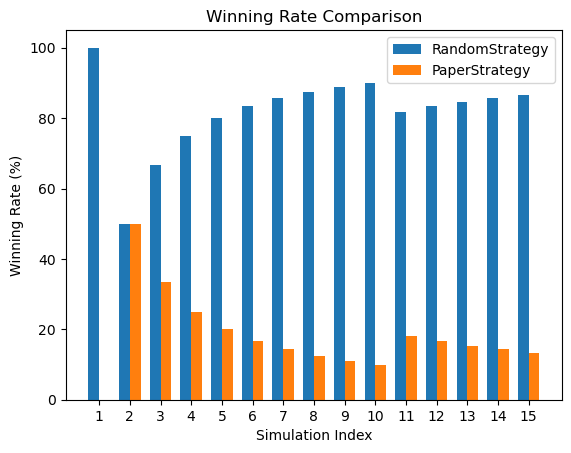

In [65]:
compare_strategies(RandomStrategy(), PaperStrategy())

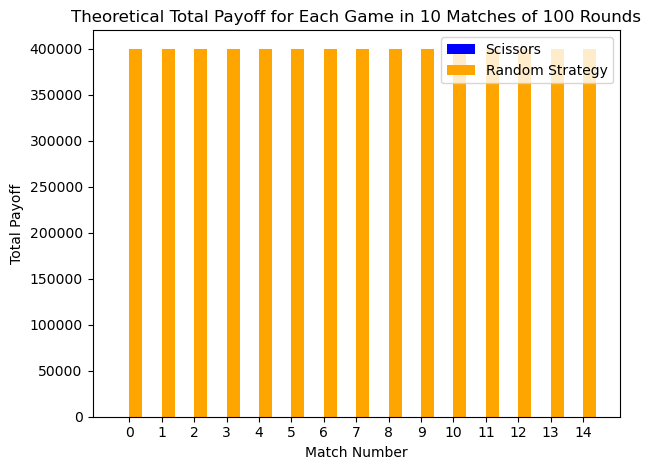

In [66]:
# Call the function with the specified payoffs
plot_theoretical_payoffs(fixed_strategy_name = 'Scissors', fixed_strategy_payoff=0, random_payoff= 400)

The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!


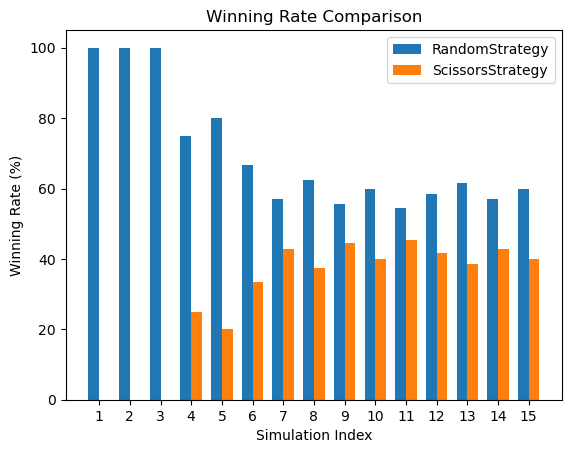

In [67]:
compare_strategies(RandomStrategy(), ScissorsStrategy())

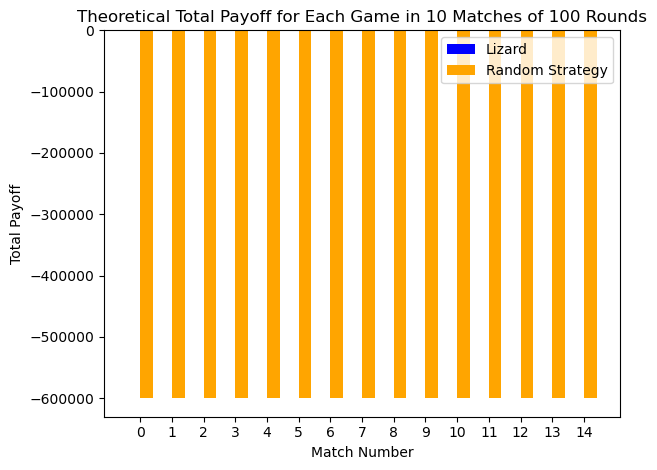

In [68]:
# Call the function with the specified payoffs
plot_theoretical_payoffs(fixed_strategy_name = 'Lizard', fixed_strategy_payoff=0, random_payoff= -600)

The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!


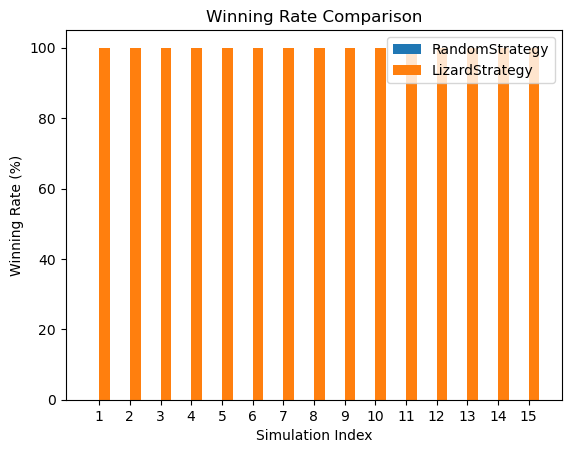

In [69]:
compare_strategies(RandomStrategy(), LizardStrategy())

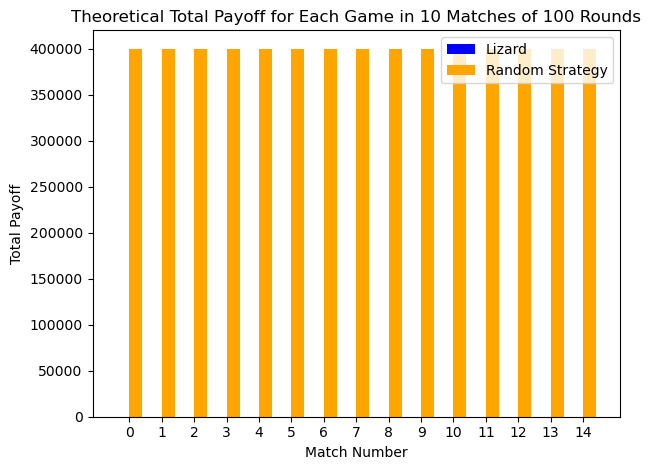

In [70]:
# Call the function with the specified payoffs
plot_theoretical_payoffs(fixed_strategy_name = 'Lizard', fixed_strategy_payoff=0, random_payoff= 400)

The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!


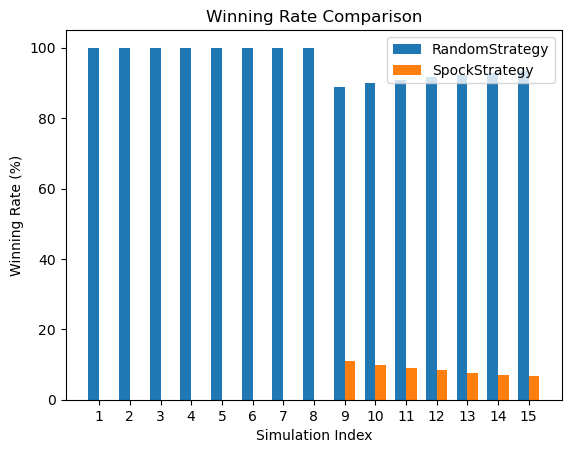

In [71]:
compare_strategies(RandomStrategy(), SpockStrategy())

The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!


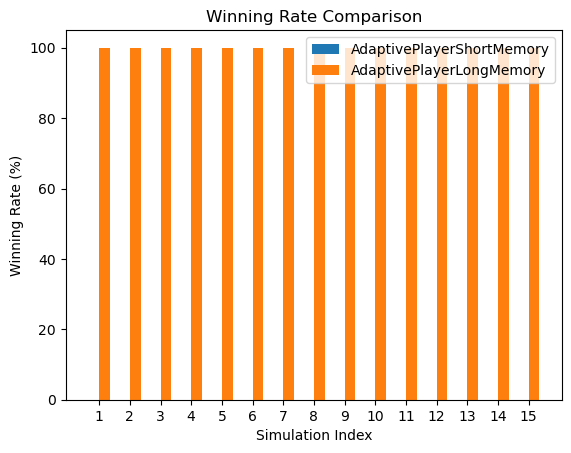

In [72]:
compare_strategies(AdaptivePlayerShortMemory(), AdaptivePlayerLongMemory())

The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!


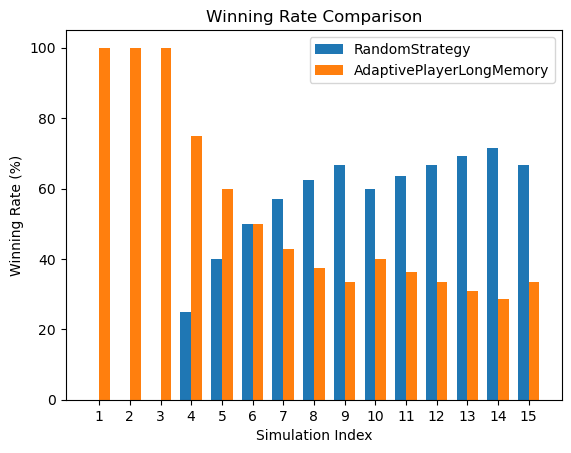

In [73]:
compare_strategies(RandomStrategy(), AdaptivePlayerLongMemory())

The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!


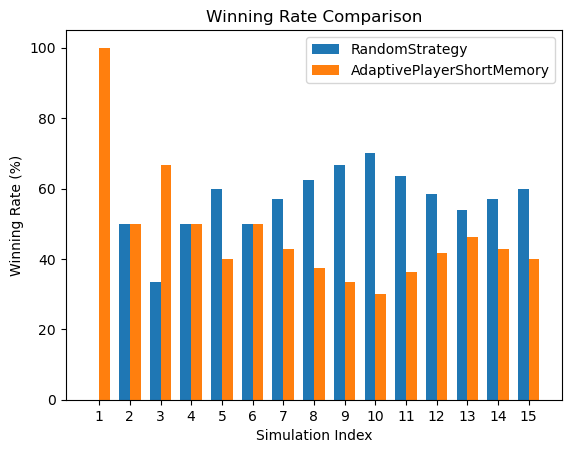

In [74]:
compare_strategies(RandomStrategy(), AdaptivePlayerShortMemory())

The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!


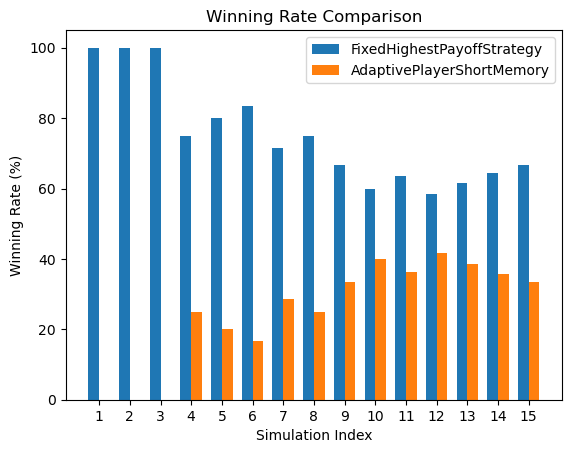

In [75]:
compare_strategies(FixedHighestPayoffStrategy(), AdaptivePlayerShortMemory())

The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!


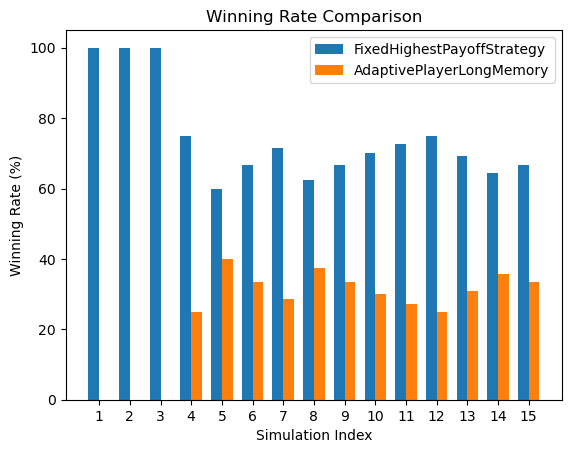

In [76]:
compare_strategies(FixedHighestPayoffStrategy(), AdaptivePlayerLongMemory())

The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!


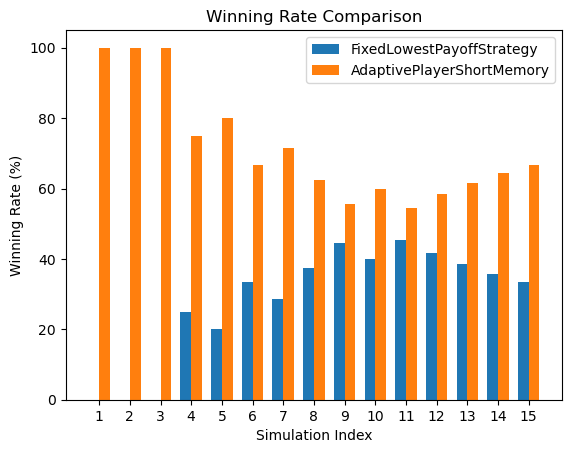

In [77]:
compare_strategies(FixedLowestPayoffStrategy(), AdaptivePlayerShortMemory())

The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!


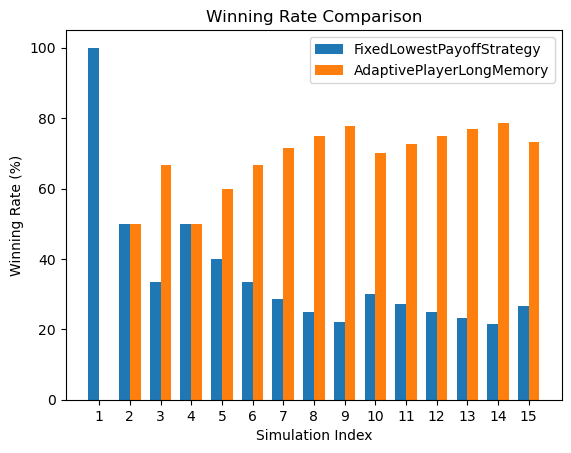

In [78]:
compare_strategies(FixedLowestPayoffStrategy(), AdaptivePlayerLongMemory())

In [79]:
# Instantiate the game with the trained QLearningStrategy and RandomStrategy
q_learning_vs_random_game = Game(q_learning_strategy, RandomStrategy())

# Play the game
q_learning_vs_random_game.play()

The winner after 1000 rounds is Player 2!


The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!


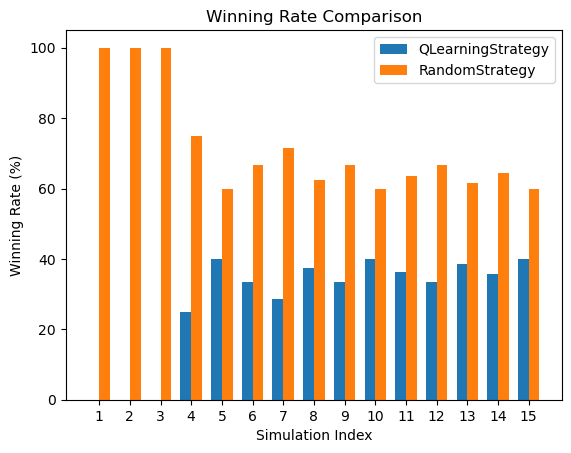

In [80]:
compare_strategies(q_learning_strategy, RandomStrategy())

The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!


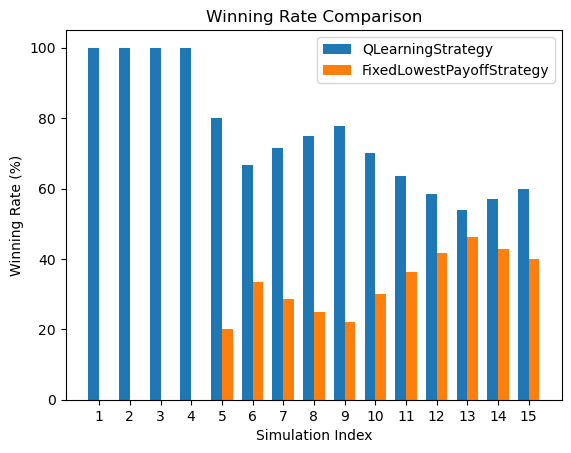

In [81]:
compare_strategies(q_learning_strategy, FixedLowestPayoffStrategy())

The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!


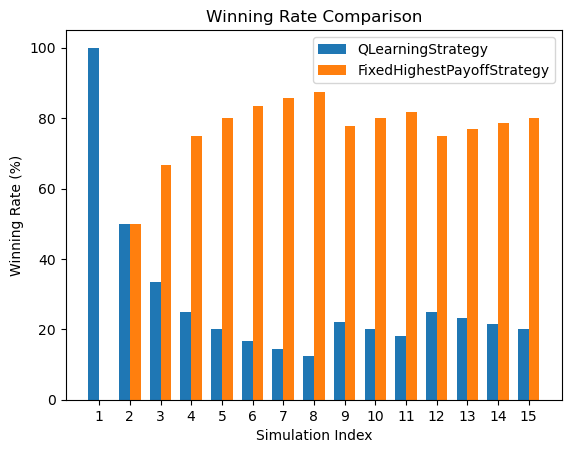

In [82]:
compare_strategies(q_learning_strategy, FixedHighestPayoffStrategy())

The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!


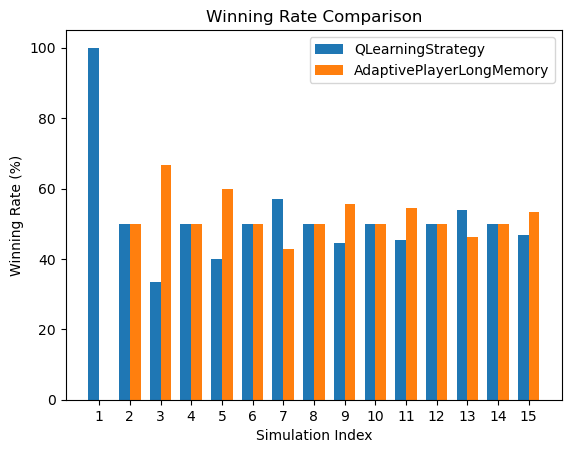

In [83]:
compare_strategies(q_learning_strategy, AdaptivePlayerLongMemory())

The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!


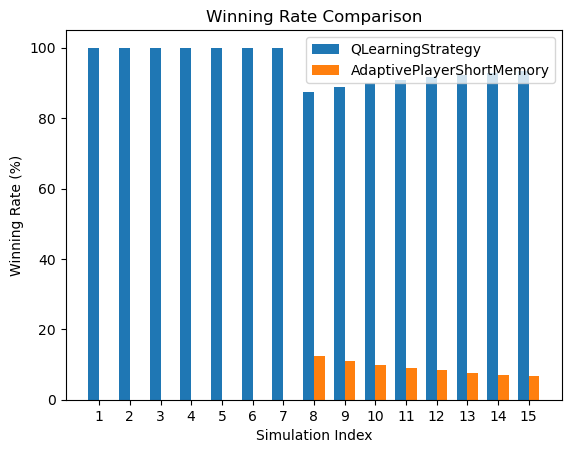

In [84]:
compare_strategies(q_learning_strategy, AdaptivePlayerShortMemory())

The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!


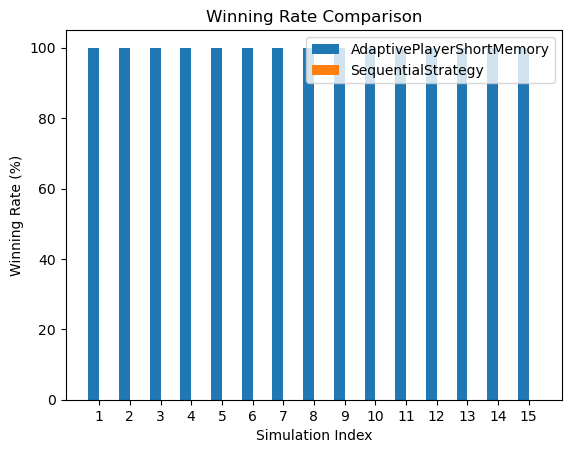

In [85]:
compare_strategies(AdaptivePlayerShortMemory(), SequentialStrategy())

The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!


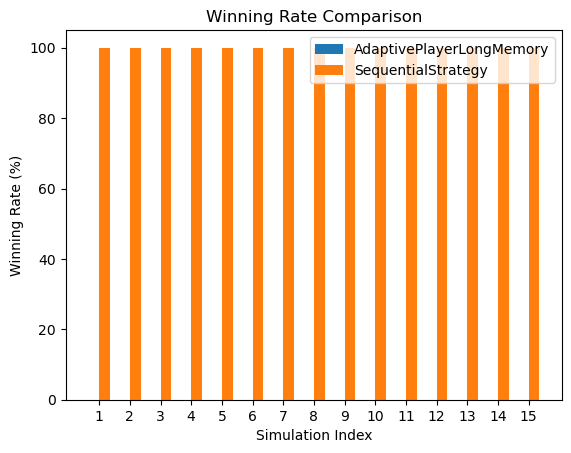

In [86]:
compare_strategies(AdaptivePlayerLongMemory(), SequentialStrategy())

The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!


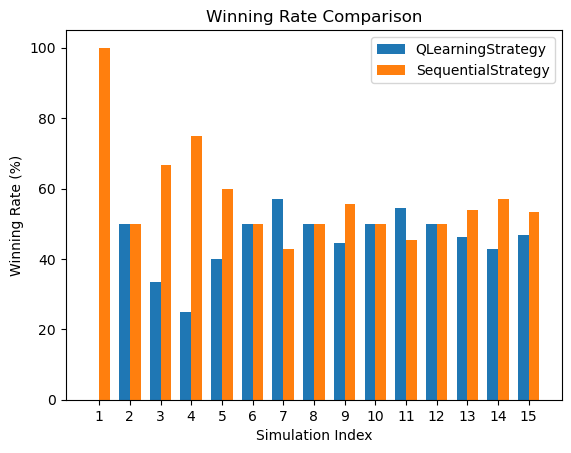

In [87]:
compare_strategies(q_learning_strategy, SequentialStrategy())

The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!


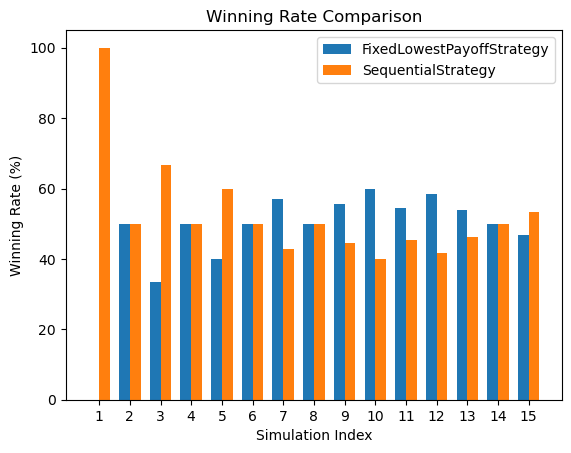

In [88]:
compare_strategies(FixedLowestPayoffStrategy(), SequentialStrategy())

The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!


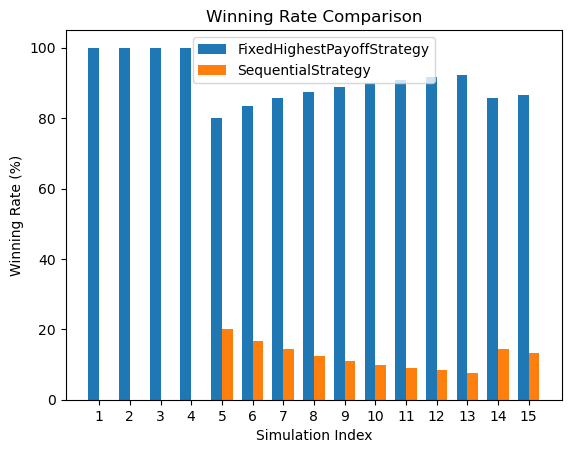

In [89]:
compare_strategies(FixedHighestPayoffStrategy(), SequentialStrategy())

In [90]:
import matplotlib.pyplot as plt
from collections import Counter

# Define the function to plot the strategy adaptation
def plot_strategy_adaptation(short_memory_strategy, long_memory_strategy, num_rounds=1000):
    # Lists to store the frequency of the most common move
    short_memory_most_common = []
    long_memory_most_common = []

    # Initialize counters for each strategy
    short_memory_counter = Counter()
    long_memory_counter = Counter()

    # Simulate the rounds
    for _ in range(num_rounds):
        # Assuming these strategies have a method `next_move` that returns a move
        short_memory_move = short_memory_strategy.next_move(None)
        long_memory_move = long_memory_strategy.next_move(None)

        # Update the counters
        short_memory_counter.update([short_memory_move])
        long_memory_counter.update([long_memory_move])

        # Calculate the frequency of the most common move
        short_freq = (short_memory_counter.most_common(1)[0][1] / (_ + 1)) * 100
        long_freq = (long_memory_counter.most_common(1)[0][1] / (_ + 1)) * 100

        # Append the frequency to the lists
        short_memory_most_common.append(short_freq)
        long_memory_most_common.append(long_freq)

    # Plotting the adaptation over time
    plt.figure(figsize=(10, 5))
    plt.plot(range(num_rounds), short_memory_most_common, label='Short Memory Strategy')
    plt.plot(range(num_rounds), long_memory_most_common, label='Long Memory Strategy')
    plt.title('Adaptive Strategy Most Common Move Frequency Over Time')
    plt.xlabel('Round Number')
    plt.ylabel('Most Common Move Frequency (%)')
    plt.legend()
    plt.show()

# Example usage (assuming you have defined strategy classes with next_move implemented):
# plot_strategy_adaptation(short_memory_strategy=ShortMemoryStrategy(), long_memory_strategy=LongMemoryStrategy())


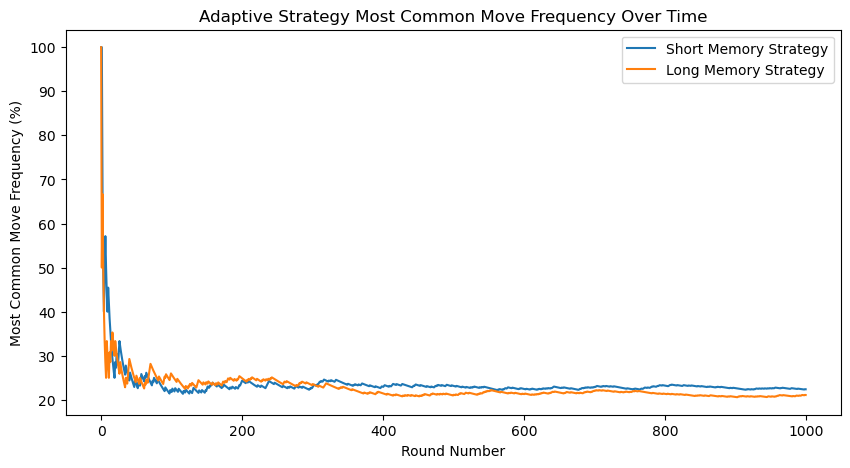

In [91]:
plot_strategy_adaptation(short_memory_strategy = AdaptivePlayerShortMemory(), long_memory_strategy = AdaptivePlayerLongMemory())

- The plot visualizes the frequency of the most common move chosen by two players employing different strategies over 1000 rounds of a game. 
- The blue line represents the Short Memory Strategy, which only considers the last three moves made by the opponent. 
- The orange line represents the Long Memory Strategy, which takes into account all of the opponent's past moves.
- Initially, there's a steep decline in the frequency for both strategies, indicating a rapid shift from the initial most common move. This suggests a quick adaptation by both players to their opponent's strategy.
- As the number of rounds increases, both lines flatten out, showing that the strategies reach a state of equilibrium. 
- The Short Memory Strategy shows more volatility, likely because it's reacting to a smaller set of recent moves, while the Long Memory Strategy is more stable, as it's informed by a larger dataset of the opponent's choices.

In [92]:
import seaborn as sns
from collections import Counter

def simulate_games(strategy1, strategy2, num_games=15, num_rounds=1000):
    results = []
    for _ in range(num_games):
        game = Game(strategy1(), strategy2(), num_rounds)
        game.play()
        results.append(game.history)
    return results

# Function to get move frequency for a specific player index in the game results
def get_move_frequency(results, player_index):
    move_frequency = {"Rock": 0, "Paper": 0, "Scissors": 0, "Lizard": 0, "Spock": 0}
    for game_history in results:
        for round_result in game_history:
            move = round_result[player_index]  # Get the move of the specified player
            move_frequency[move] += 1
    return move_frequency



In [93]:
# Function to plot heatmap comparing move frequency between two strategies
def plot_heatmap(freq1, freq2, strategy1_title, strategy2_title):
    moves = list(freq1.keys())
    frequencies = [list(freq1.values()), list(freq2.values())]
    sns.heatmap(np.array(frequencies), cmap="YlGnBu", xticklabels=moves, yticklabels=[strategy1_title, strategy2_title], cbar=False)
    plt.xlabel('Moves')
    plt.ylabel('Strategy')
    plt.title(f"{strategy1_title} vs {strategy2_title} Move Frequency")
    plt.show()



The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The game is a draw after 100 rounds.
The game is a draw after 100 rounds.
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The game is a draw after 100 rounds.
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 1!
The game is a draw after 100 rounds.
The winner after 1000 rounds is Player 2!
The winner a

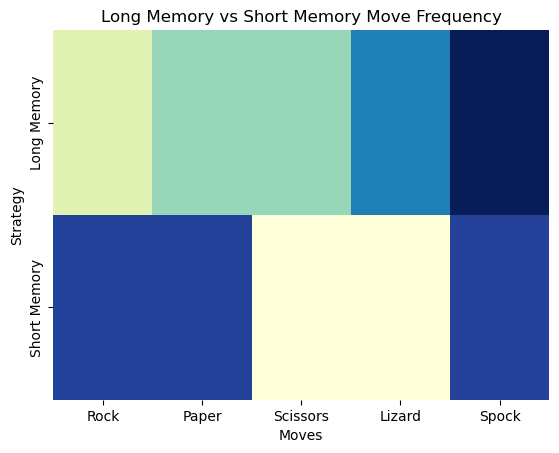

In [94]:
# Example usage:
long_memory_results = simulate_games(AdaptivePlayerLongMemory, AdaptivePlayerLongMemory)
short_memory_results = simulate_games(AdaptivePlayerShortMemory, AdaptivePlayerShortMemory)

long_memory_move_frequency = get_move_frequency(long_memory_results, 1)  # 1 indicates Player 2's move
short_memory_move_frequency = get_move_frequency(short_memory_results, 1)  # 1 indicates Player 2's move

plot_heatmap(long_memory_move_frequency, short_memory_move_frequency, "Long Memory", "Short Memory")


#the short memory strategy has the same values and colors as the long memory strategy, it could indicate that both strategies are making similar move choices

In [95]:
# Function to plot heatmap comparing move frequency between two strategies
def plot_heatmap_greyscale(freq1, freq2, strategy1_title, strategy2_title):
    moves = list(freq1.keys())
    frequencies = [list(freq1.values()), list(freq2.values())]
    cmap = sns.light_palette("blue", as_cmap=True)
    plt.figure(figsize=(10, 5))
    sns.heatmap(np.array(frequencies), cmap=cmap, xticklabels=moves, yticklabels=["Long Memory", "Short Memory"], cbar=False)
    plt.xlabel('Moves')
    plt.ylabel('Strategy')
    plt.title(f"{strategy1_title} vs {strategy2_title} Move Frequency")
    plt.show()



The winner after 1000 rounds is Player 1!
The game is a draw after 100 rounds.
The game is a draw after 100 rounds.
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The game is a draw after 100 rounds.
The winner after 1000 rounds is Player 1!
The game is a draw after 100 rounds.
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 2!
The game is a draw after 100 rounds.
The winner after 1000 rounds is Player 2!
The winner after 1000 rounds is Player 1!
The game is a draw after 100 rounds.
The winner after 1000 rounds is Player 1!
The winner after 1000 

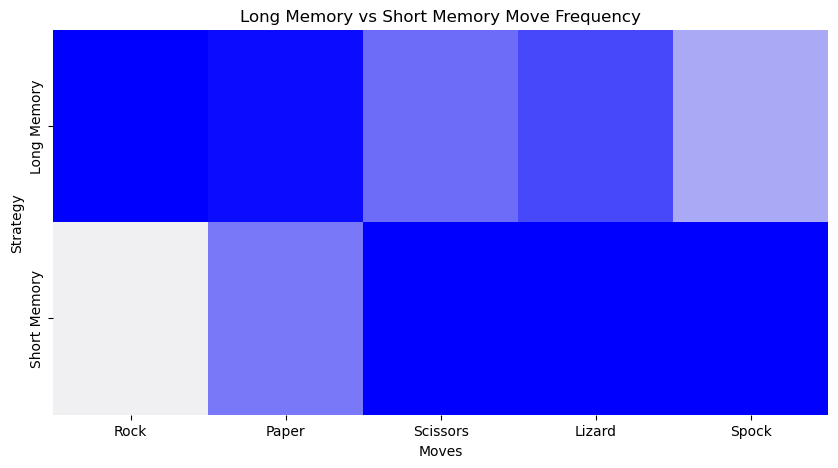

In [96]:
# Example usage:
long_memory_results = simulate_games(AdaptivePlayerLongMemory, AdaptivePlayerLongMemory)
short_memory_results = simulate_games(AdaptivePlayerShortMemory, AdaptivePlayerShortMemory)

long_memory_move_frequency = get_move_frequency(long_memory_results, 1)  # 1 indicates Player 2's move
short_memory_move_frequency = get_move_frequency(short_memory_results, 1)  # 1 indicates Player 2's move

plot_heatmap_greyscale(long_memory_move_frequency, short_memory_move_frequency, "Long Memory", "Short Memory")


#the short memory strategy has the same values and colors as the long memory strategy, it could indicate that both strategies are making similar move choices

In [97]:
! pip install ffmpeg-python

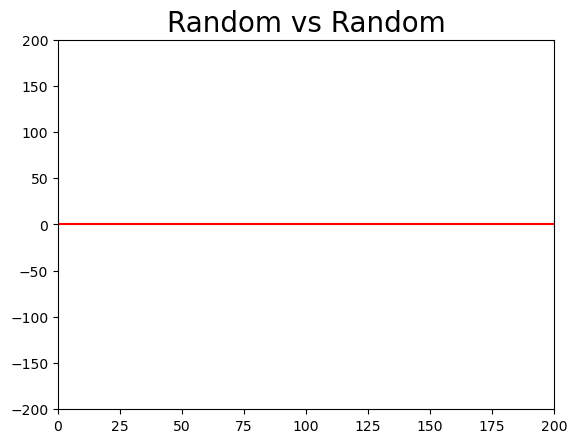

FileNotFoundError: [WinError 2] The system cannot find the file specified

In [115]:
# https://matplotlib.org/stable/users/explain/animations/animations.html
# https://www.geeksforgeeks.org/how-to-create-animations-in-python/
from matplotlib import pyplot as plt
import matplotlib.animation as animation 
from matplotlib.animation import FuncAnimation
from matplotlib.artist import Artist
import numpy as np
import random
from IPython.display import HTML

moves_dic = {1:'Rock', 2:'Paper', 3:'Scissors', 4:'Lizard', 5:'Spock'}
gestures = {
    "Rock": {"wins": ["Scissors", "Lizard"], "winning_points": 1, "losing_points": -1},
    "Paper": {"wins": ["Rock", "Spock"], "winning_points": 2, "losing_points": -2},
    "Scissors": {"wins": ["Paper", "Lizard"], "winning_points": 3, "losing_points": -3},
    "Lizard": {"wins": ["Spock", "Paper"], "winning_points": 4, "losing_points": -4},
    "Spock": {"wins": ["Scissors", "Rock"], "winning_points": 5, "losing_points": -5}
}

tick_time = 50
frame_list = []
scores = [0, 0]
palette = ['blue', 'red', 'green', 'darkorange', 'maroon', 'black']

def generate_animation(player1_moves, player2_moves, title_str, tick_time):

	round_num = len(player1_moves)
	
	figure, ax = plt.subplots() # figsize=(16,8)
	plt.title(title_str, fontsize = 20)
	plt.axhline(y=0, color='r', linestyle='-')
	# Setting limits for x and y axis
	ax.set_xlim(0, round_num)
	ax.set_ylim(-round_num, round_num)
	# Since plotting a single graph
	line,  = ax.plot(0, 0) 
	
	# how many ticks
	
	ticks, score_dif = [], []

	def animation_function(i):
		global frame_list, score1, score2
		
		action01 = player1_moves[i]
		action02 = player2_moves[i]
		s1, s2 = 0, 0
		if action02 in gestures[action01]['wins']:
			s1 = gestures[action01]['winning_points']
			s2 = gestures[action02]['losing_points']
		elif action01 in gestures[action02]['wins']:
			s1 = gestures[action01]['losing_points']
			s2 = gestures[action02]['winning_points']
		scores[0] += s1
		scores[1] += s2 
		s1 = "+" + str(s1) if s1>0 else str(s1)
		s2 = "+" + str(s2) if s2>0 else str(s2)
		
		
		for f in frame_list: Artist.remove(f)
		# actions 
		f1 = plt.text(round(0.1*round_num), round(0.5*round_num), action01, fontsize = 20, color='maroon')
		f2 = plt.text(round(0.8*round_num), round(0.5*round_num), action02, fontsize = 20, color='maroon')
		f3 = plt.text(round(0.5*round_num), round(0.5*round_num), "vs", fontsize = 20, color='darkorange')
		# winning/losing scores
		f4 = plt.text(round(0.2*round_num), round(0.65*round_num), s1, fontsize = 15, color='red')
		f5 = plt.text(round(0.9*round_num), round(0.65*round_num), s2, fontsize = 15, color='red')
		# cumulative scores
		f6 = plt.text(round(0.1*round_num), round(0.8*round_num), "P 1: "+str(scores[0]), fontsize = 15, color='purple')
		f7 = plt.text(round(0.8*round_num), round(0.8*round_num), "P 2: "+str(scores[1]), fontsize = 15, color='purple')
		# round number
		f8 = plt.text(round(0.4*round_num), round(0.8*round_num), "Round: " + str(i+1), fontsize = 15, color='blue')
		
		ticks.append(i)
		score_dif.append(scores[0] - scores[1])
		line.set_xdata(ticks)
		line.set_ydata(score_dif)
		
		if i+1==round_num: 
			win_msg = "player 1 win!" if scores[0]>scores[1] else "player 2 win!"
			f9 = plt.text(round(0.25*round_num), round(0.3*round_num), win_msg, fontsize = 30, color='red')
			frame_list = [f1, f2, f3, f4, f5, f6, f7, f8, f9]
		else:
			frame_list = [f1, f2, f3, f4, f5, f6, f7, f8]
		return line,
	
	# fargs = (frame_list, scores),
	anim = FuncAnimation(figure,
							  func = animation_function,
							  frames = np.arange(0, round_num, 1), 
							  interval = tick_time,
							  repeat = False)
	plt.show()
	#with open("/Users/xiaoyao/Desktop/Programming/python_workspace/TurinTech/myvideo.html", "w") as f:
		#HTML(anim.to_html5_video())
	writervideo = animation.FFMpegWriter(fps=60)
	anim.save("C:/Users/theod/Desktop/UNI/Master's/Sem 2/Agents/Coursework/anim2.mp4", writer=writervideo)
	plt.close() 
	return



round_num = 200
player1_moves = []
player2_moves = []
for i in range(round_num): player1_moves.append( moves_dic[random.randint(1, 5)] )
for i in range(round_num): player2_moves.append( moves_dic[random.randint(1, 5)] )
title_str = "Random vs Random"
generate_animation(player1_moves, player2_moves, title_str, tick_time) 